Using TensorFlow backend.


Img_path and measurements : (6198,) (6198,)
Epoch 1/5
9916/9916 [==============================] - 273s - loss: 0.0495 - val_loss: 0.0425
Epoch 2/5
9916/9916 [==============================] - 271s - loss: 0.0388 - val_loss: 0.0340
Epoch 3/5
9916/9916 [==============================] - 272s - loss: 0.0331 - val_loss: 0.0309
Epoch 4/5
9916/9916 [==============================] - 4266s - loss: 0.0288 - val_loss: 0.0282
Epoch 5/5
9916/9916 [==============================] - 275s - loss: 0.0253 - val_loss: 0.0251
dict_keys(['val_loss', 'loss'])
Loss
[0.049507646901460124, 0.038759115758040537, 0.033071025060177957, 0.028769348710459799, 0.02533121678614542]
Validation Loss
[0.042452909148508501, 0.033959613980785494, 0.030898059351790335, 0.028196788555191411, 0.025075906803531032]


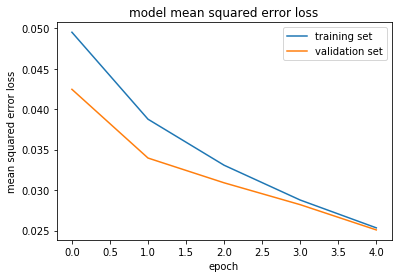

In [1]:
##
## Udacity PRORJECT
## Code Reference - Behaviour Cloning Classes
##

import csv 
import cv2
import numpy as np
from keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, Input, Lambda, SpatialDropout2D,MaxPooling2D
from keras.layers import Cropping2D
import sklearn
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

##
##  Read the data from driving_log generated using the simulator in training mode
## 
lines = []
with open("data/driving_log.csv") as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)

#
#  Reading the images center,left,right images with no steering angle correction
#  Commenting this out as loading too many images in memory not efficient instead going to use generator 
#
'''
images = []
measurements =[]
for line in lines:
    for i in range(3):
        source_path = line[i]
        # The m/c is same as the m/c where data is generated so no need to make any correction in the path
        current_path = source_path
        image = cv2.imread(current_path)
        images.append(image)
        measurement = float(line[3])
        measurements.append(measurement);
'''        
        
#
#  Reading the img_paths (center,left,right img path and taking sterring angle correction for left, right into account)
#
img_paths = []
measurements =[]
for line in lines:
    ## Read Center,left,right images (More the data better the training)
    steering_center = float(line[3])

    # create adjusted steering measurements for the side camera images
    correction = 0.20 # Tuned it after multiple iteration {Ideally it can be calculated mathematically}
    steering_left = steering_center + correction
    steering_right = steering_center - correction

    # read in images from center, left and right cameras
    # directory = "..." # fill in the path to your training IMG directory
    img_center = line[0]
    img_left = line[1]
    img_right = line[2]

    # add images 
    img_paths.append(img_center)
    img_paths.append(img_left)
    img_paths.append(img_right)
    
    # add measuremnts 
    measurements.append(steering_center)
    measurements.append(steering_left)
    measurements.append(steering_right)
    

img_paths = np.array(img_paths)
measurements = np.array(measurements)
print('Img_path and measurements :', img_paths.shape, measurements.shape)

##
##
from sklearn.model_selection import train_test_split
#samples = list(zip(augmented_images, augmented_measurements))
samples = list(zip(img_paths, measurements))
train_samples, validation_samples = train_test_split(samples, test_size=0.2)



## Regression Network
from keras.models import Sequential
from keras.layers import Flatten, Dense


def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for path,measurement in batch_samples:

                #print(path)
                #print(measurement)
                
                image = cv2.imread(path)
                angle = float(measurement)
                
                images.append(image)
                angles.append(angle)
                
                # Augumented Image
                images.append(cv2.flip(image,1))
                angles.append(angle*-1.0)


            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)
            
               
            
train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)


model = Sequential()
#model.add(Flatten(input_shape=(160,320,3)))
model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(160,320,3)))
#model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3])))
# Crop the top 50% as it is mostly sky, and the bottom 20% as it is hood of the car 
model.add(Cropping2D(cropping=((50,20),(0,0))))
#model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(160,320,3)))

#model.add(Flatten(input_shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3])))
#model.add(Flatten())
#model.add(Dense(1))


#train_generator = generator(train_samples, batch_size=32)
#validation_generator = generator(validation_samples, batch_size=32)

#model = Sequential()
#model.add(Lambda(lambda x:x/255.0 - 0.5,input_shape=(160,320,3)))
#model.add(Cropping2D(cropping=((50,20),(0,0))))

'''Google LeNet
model.add(Convolution2D(6,5,5,activation="relu"))
model.add(MaxPooling2D())
model.add(Convolution2D(6,5,5,activation="relu"))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(120))
model.add(Dense(84))
model.add(Dense(1))
'''

# NVDIA
model.add(Convolution2D(24,5,5,subsample=(2,2),activation="relu"))
model.add(Convolution2D(36,5,5,subsample=(2,2),activation="relu"))
model.add(Convolution2D(48,5,5,subsample=(2,2),activation="relu"))
model.add(Convolution2D(64,3,3,activation="relu"))
model.add(Convolution2D(64,3,3,activation="relu"))
model.add(Flatten())
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))

model.compile(loss="mse", optimizer="adam")
##model.fit(x_train, y_train, validation_split=0.2, shuffle=True, nb_epoch=2)
##model.save("model.h5")

history_object = model.fit_generator(train_generator, samples_per_epoch= len(train_samples)*2, validation_data=validation_generator, nb_val_samples=len(validation_samples)*2, nb_epoch=5, verbose =1)
model.save('model.h5')

### Visualization -Outputting Training and Validation Loss Metrics
#history_object = model.fit_generator(train_generator, samples_per_epoch= len(train_samples), validation_data=validation_generator, nb_val_samples=len(validation_samples), nb_epoch=2, verbose =1)
#history_object = model.fit_generator(train_generator, samples_per_epoch= len(train_samples)*2, validation_data=validation_generator, nb_val_samples=len(validation_samples)*2, nb_epoch=3, verbose =1)


### print the keys contained in the history object
print(history_object.history.keys())
print('Loss')
print(history_object.history['loss'])
print('Validation Loss')
print(history_object.history['val_loss'])

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()




# 